In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
#import seaborn as sns 
from datetime import datetime, timedelta
import pytz
from zoneinfo import ZoneInfo

In [3]:
# Name files 
#filename = '20220404_20220408_Modesto.tot_lev20'
#filename = '20190201_20190228_Grizzly_Bay.tot_lev20' # Feburary, 2019
#filename = '20190301_20190331_Grizzly_Bay.tot_lev20' # March, 2019
filename = 'AERONET_Data/20190801_20190831_Grizzly_Bay.tot_lev20' # August, 2019

# Load Files 
df = pd.read_csv(filename,skiprows = 6)

# Visible light is within 380nm and 700nm
listOfHeaders = []
for i in df.columns: # Captures only wavelengths between 380nm and 750nm
    if ('total' in i.lower()) and ('nm' in i.lower()) and ('aod' in i.lower()):
        if 380 <= int(i[4:7]) <= 750:
            listOfHeaders.append(i)
            #print(i[4:7])
print('Number of wavelengths between 380nm and 750nm: ', len(listOfHeaders), '\n', listOfHeaders)
#selectedData = listOfHeaders[11] # AOD_443nm-Total
selectedData = listOfHeaders[11] # Increment/Decrement this (0 to 17) to choose a wavelength
#selectedData = 'AOD_443nm-Total' # Alternatively, uncomment this and type in the wavelength we want to select.
print('Currently Selected Header: ', selectedData)

Number of wavelengths between 380nm and 750nm:  18 
 ['AOD_675nm-Total', 'AOD_667nm-Total', 'AOD_620nm-Total', 'AOD_560nm-Total', 'AOD_555nm-Total', 'AOD_551nm-Total', 'AOD_532nm-Total', 'AOD_531nm-Total', 'AOD_510nm-Total', 'AOD_500nm-Total', 'AOD_490nm-Total', 'AOD_443nm-Total', 'AOD_440nm-Total', 'AOD_412nm-Total', 'AOD_400nm-Total', 'AOD_380nm-Total', 'AOD_681nm-Total', 'AOD_709nm-Total']
Currently Selected Header:  AOD_443nm-Total


In [4]:
# Combine dates and times 
TimeDate = df['Date(dd:mm:yyyy)'] + ' '+df['Time(hh:mm:ss)'] 

In [5]:
# Initialize dates 
# Format for the datetime function: datetime(year,month,day)
#registeredStartDate = datetime(2019,1,1) # Starts Jan 1st, 2019
#registeredStartDate = datetime(2019,2,1) # Starts Feb 1st, 2019
#registeredStartDate = datetime(2019,3,1) # Starts Mar 1st, 2019
#registeredStartDate = datetime(2019,4,1) # Starts Apr 1st, 2019
registeredStartDate = datetime(2019,8,1) # Starts Aug 1st, 2019

print(registeredStartDate)

2019-08-01 00:00:00


In [6]:
# Parse the data

# Store GMT Data 
GMT = [] # This our GMT_time 
for i in TimeDate: 
    dt = datetime.strptime(i,"%d:%m:%Y %H:%M:%S") # Stripped information from each row 
    GMT.append(dt)   
    
# Convert GMT to Local Time

#PDT_time = []  
T = pd.Series(data=GMT) # Inputting GMT_time into a series 

# Converts GMT Dates and Times to Pacific Daylight Savings Time 
local_Date_time = T.dt.tz_localize('GMT').dt.tz_convert('America/Los_Angeles').dt.tz_localize(None) # This line converts time_zones

# Storing local dates and times into list  
PDT_Date_time = []
for i in local_Date_time: 
    dt_objects = i.to_pydatetime() # Turns the timestamps to datetime objects 
    PDT_Date_time.append(dt_objects)
    
# Find the total seconds starting the week of april 4th 

PDT_time = [] # official PDT time 

for i in PDT_Date_time: # Takes time in 
    
    timediff = i.timestamp() - registeredStartDate.timestamp()
    
    PDT_time.append(timediff)
    
print(PDT_Date_time[0])
print(PDT_Date_time[0]- registeredStartDate)
print(PDT_time[0])
print(abs(df[selectedData].mean())**2)
print(abs(np.mean(df[selectedData]))**2)

2019-08-01 09:20:09
9:20:09
33609.0
0.1050727931921161
0.1050727931921161


In [7]:
# Code Block implemented by Anthony Castillo 

# This rootMeanSquareDeviation Function will be used for calculating the error bars of each 3 hour grouping
def rootMeanSquareDeviation(integerArray): # Computes the standard deviation of any given integer array
    sum = 0
    if len(integerArray) == 1:
        if integerArray[0] == -999.0:
            return 0
        else:
            return integerArray[0]**5 # This brings the error bars into suit with the rest of the bars.
    for x in integerArray:
        if x == -999.0: # This value would mess up the calculations, however this x should never be -999.0
            x = np.mean(integerArray)
        sum = sum + (x-np.mean(integerArray))**2
    return (np.sqrt(sum/len(integerArray)) * np.sqrt(2))

stdDeviation = rootMeanSquareDeviation(df[selectedData])
meanData = abs(df[selectedData].mean())
medianData = abs(df[selectedData].median()) # Not used
print('RMSD: ', rootMeanSquareDeviation(df[selectedData]))
print('Mean of Data: ', meanData)
print('Median of Data: ', medianData)

# 7pm = 19hrs*3600s = 68,400s 
# 7am = 7hrs*3600s = 25,200s
# 24hrs = 86400s
secondsPerDay, upperLimit, lowerLimit = 86400, 19*3600, 7*3600
# Here we are grouping elements together that are withing a 3 hour strech of one another
df_Mean, df_MeanErrors, threeHourGap, tempTimeAxis, timeAxis = [], [], [], [], []
for index, value in enumerate(df[selectedData]): # Iterate thru the data getting the index and value of each element
    if lowerLimit > PDT_time[index]-secondsPerDay*(PDT_time[index] // secondsPerDay) or PDT_time[index]-secondsPerDay*(PDT_time[index] // secondsPerDay) > upperLimit: # Skipping indexes which are beyond 7pm.
        print('Skipping ', index, ' outside of desired time range.')
        continue
    if not (meanData-stdDeviation*2 <= abs(value) <= meanData+stdDeviation*2): # Removing data that is too far away from the total mean of the data
        print('Removing: ', PDT_time[index], local_Date_time.loc[index], df[selectedData].loc[index], 'Reason: Too far from mean.')
        df.drop(index=index, inplace=True)
        PDT_time[index] = None
        local_Date_time.drop(index=index, inplace=True)
        continue
    startTime, endTime = 0-3600*2, 10800-3600*2 # 10800 seconds every 3 hours - 3600 to start the counting at 11pm instead of midnight
    notAppended, count = True, 0
    while notAppended: # Dynamically placing the data into the correct array by resetting startTime, endTime, and count on each new index, value iteration
        if startTime <= PDT_time[index] < endTime:
            while len(threeHourGap) <= count: # If the array is smaller than what we've counted, we'll add empty arrays to our list
                threeHourGap.append([])
                tempTimeAxis.append([])
            threeHourGap[count].append(value) # Appending the floating point value to the array at location count in threeHourGap
            tempTimeAxis[count].append(PDT_time[index]) # Appending the PDT_time to tempTimeAxis at location count 
            notAppended = False # Flip to end the while loop
        elif startTime >= registeredStartDate.timestamp()**3: # If we've gone way over
            threeHourGap.append([]) # Adding empty lists.
            tempTimeAxis.append([])
            notAppended = False
        else: # While the PDT_time element is not within the range, we'll incrememnt our count, start, and end times by three hours 3*60*60
            count += 1
            startTime += 10800
            endTime += 10800

# Now we'll go back thru and convert the arrays into single point means by passing the array into the rootMeanSquareDeviation function above
count = 0
for i, v in enumerate(threeHourGap): 
    if v == []: # Skipping empty arrays
        continue
    df_Mean.append(np.mean(threeHourGap[i])) # Finding the root mean square of each data array
    df_MeanErrors.append(abs(rootMeanSquareDeviation(threeHourGap[i])))
    timeAxis.append(tempTimeAxis[i][len(tempTimeAxis[i])//2]) # Get the middle time of each mean data point
    count += 1
    
print(df_Mean)
print(df_MeanErrors)

# Cleaning up the indexes from the removed data points
PDT_temp = []
for i in PDT_time: # Adding non-removed attributes to a new list
    if i == None:
        continue
    else:
        PDT_temp.append(i)
PDT_time.clear() # Clear old list
PDT_time = PDT_temp # Set old list to new list
df.reset_index(drop=True, inplace=True) # Re-does the indexes for the pandas.Series, takes dropped rows into consideration.
local_Date_time.reset_index(drop=True, inplace=True) # Re-does the indexes for the pandas.Series, takes dropped rows into consideration.

print('Lenght of datasets are: ', len(PDT_time), len(local_Date_time), len(df))

del threeHourGap, tempTimeAxis, startTime, endTime, notAppended, count # Clearing variables that are no longer needed. Not needed, but clears up memory.

RMSD:  0.9228102673851535
Mean of Data:  0.3241493377937337
Median of Data:  0.322861
Skipping  109  outside of desired time range.
Skipping  110  outside of desired time range.
Skipping  111  outside of desired time range.
Skipping  112  outside of desired time range.
Skipping  222  outside of desired time range.
Skipping  223  outside of desired time range.
Skipping  224  outside of desired time range.
Skipping  225  outside of desired time range.
Skipping  226  outside of desired time range.
Skipping  227  outside of desired time range.
Skipping  228  outside of desired time range.
Skipping  229  outside of desired time range.
Skipping  341  outside of desired time range.
Skipping  342  outside of desired time range.
Skipping  343  outside of desired time range.
Skipping  344  outside of desired time range.
Skipping  345  outside of desired time range.
Skipping  346  outside of desired time range.
Skipping  347  outside of desired time range.
Skipping  458  outside of desired time r

/tmp/ipykernel_1499/3010373898.py:38: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  local_Date_time.drop(index=index, inplace=True)
/tmp/ipykernel_1499/3010373898.py:38: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  local_Date_time.drop(index=index, inplace=True)


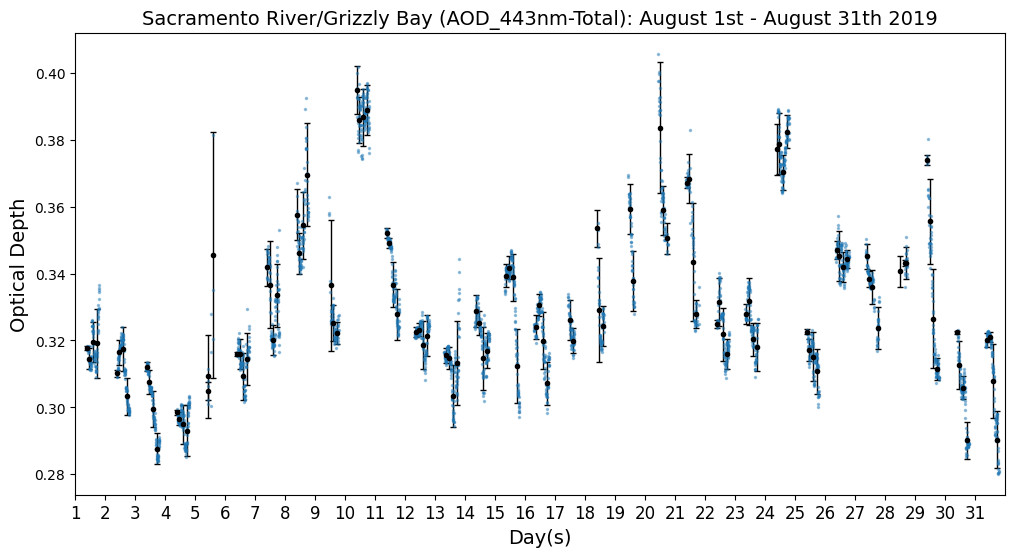

In [9]:
# Sacramento River/Grizzly Bay: Feburary 1st - Feburary 28th 2019
fig = plt.figure(figsize = (12,6))

plt.errorbar(timeAxis,df_Mean,yerr=df_MeanErrors,fmt='.',color='black',markersize=5,elinewidth=1,capsize=2,label='AOD')
plt.plot(PDT_time,df[selectedData],'.',color='C0',markersize=3,alpha=0.4) # C0, C1, C2, C3 cycles through the default colors
plt.plot(timeAxis,df_Mean,'.',color='black')

# Change the title to fit your station
title0 = 'Sacramento River/Grizzly Bay (' + selectedData + '): Feburary 1st - Feburary 28th 2019'
title1 = 'Sacramento River/Grizzly Bay (' + selectedData + '): August 1st - August 31th 2019'
title2 = 'Sacramento River/Grizzly Bay (' + selectedData + '): January 1st - January 31th 2019'
title3 = 'Sacramento River/Grizzly Bay (' + selectedData + '): March 1st - March 31th 2019'
title4 = 'Sacramento River/Grizzly Bay (' + selectedData + '): April 1st - April 30th 2019'

days = 31 # Adjust the number of days to fit the current month

plt.title(title1,fontsize = 14)

plt.xlabel('Day(s)',fontsize = 14)

plt.ylabel('Optical Depth',fontsize = 14)

x_label = [str(i+1) for i in range(days)]

plt.xticks(np.arange(days)*24*3600,x_label,fontsize = 12) # Sets x-ticks for the week  

plt.xlim([24*3600*0,24*3600*days])
#plt.ylim([-0.1,0.9]) # Not needed, the plots should automatically adjust based on the available data

# To save the graph, adjust the names of the folders below and the name of the files themselves.
#filename = 'Sacramento_River_2019_January_' + selectedData
#location = 'graphs\\Sacramento River 2019 January\\' + filename

#filename = 'Sacramento_River_2019_Feburary' + selectedData
#location = 'graphs\\Sacramento River 2019 Feburary\\' + filename

#filename = 'Sacramento_River_2019_March_' + selectedData
#location = 'graphs\\Sacramento River 2019 March\\' + filename

#filename = 'Sacramento_River_2019_April' + selectedData
#location = 'graphs\\Sacramento River 2019 April\\' + filename

filename = 'Sacramento_River_2019_August_' + selectedData
location = 'graphs\\Sacramento River 2019 August\\' + filename

plt.savefig(location) # Saves the plot to a .png file.
plt.show()

In [10]:
for i in list(df): # Displays all of the aod total wavelengths available in this dataset
    if ('total' in i.lower()) and ('aod' in i.lower()) and ('nm' in i.lower()):
        print(i)

AOD_1640nm-Total
AOD_1020nm-Total
AOD_870nm-Total
AOD_865nm-Total
AOD_779nm-Total
AOD_675nm-Total
AOD_667nm-Total
AOD_620nm-Total
AOD_560nm-Total
AOD_555nm-Total
AOD_551nm-Total
AOD_532nm-Total
AOD_531nm-Total
AOD_510nm-Total
AOD_500nm-Total
AOD_490nm-Total
AOD_443nm-Total
AOD_440nm-Total
AOD_412nm-Total
AOD_400nm-Total
AOD_380nm-Total
AOD_340nm-Total
AOD_681nm-Total
AOD_709nm-Total


In [11]:
# Additional Debugging, displaying data and times
print(len(PDT_time), len(local_Date_time), len(df))
print(local_Date_time.loc[len(local_Date_time)/2])
print(df[selectedData].loc[len(df[selectedData])/2])

for i, v in enumerate(PDT_time):
    print(v, v//10800, local_Date_time.loc[i], df[selectedData].loc[i])#datetime.fromtimestamp(v), df[selectedData][i])

3062 3062 3062
2019-08-15 12:22:26
0.344402
33609.0 3.0 2019-08-01 09:20:09 0.317381
33767.0 3.0 2019-08-01 09:22:47 0.317332
34200.0 3.0 2019-08-01 09:30:00 0.318105
34649.0 3.0 2019-08-01 09:37:29 0.318463
34810.0 3.0 2019-08-01 09:40:10 0.317223
35110.0 3.0 2019-08-01 09:45:10 0.317458
35230.0 3.0 2019-08-01 09:47:10 0.317464
35708.0 3.0 2019-08-01 09:55:08 0.318147
36010.0 3.0 2019-08-01 10:00:10 0.317993
36310.0 3.0 2019-08-01 10:05:10 0.317144
36610.0 3.0 2019-08-01 10:10:10 0.316395
36910.0 3.0 2019-08-01 10:15:10 0.317083
37347.0 3.0 2019-08-01 10:22:27 0.317437
37803.0 3.0 2019-08-01 10:30:03 0.316882
38101.0 3.0 2019-08-01 10:35:01 0.317098
38410.0 3.0 2019-08-01 10:40:10 0.317643
38710.0 3.0 2019-08-01 10:45:10 0.317952
38832.0 3.0 2019-08-01 10:47:12 0.318468
39309.0 3.0 2019-08-01 10:55:09 0.316423
39610.0 3.0 2019-08-01 11:00:10 0.31405
39910.0 3.0 2019-08-01 11:05:10 0.314418
40210.0 3.0 2019-08-01 11:10:10 0.313895
40510.0 3.0 2019-08-01 11:15:10 0.313662
40978.0 3.0 20